<a href="https://colab.research.google.com/github/laribar/TechChallenge2/blob/main/TechChallenge_2_Rev01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [486]:
#!pip install yfinance --upgrade --no-cache-dir
#!pip install xgboost


In [487]:
# Análise de dados e manipulação
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns



from statsmodels.tsa.stattools import adfuller

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor


# pegar os dados
import yfinance as yf
# Manipulação de datas
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay
import matplotlib.dates as mdates
#extras
import warnings
import logging
from tqdm import tqdm
import yfinance as yf
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Verificação de versões (opcional)
import sklearn
print(f"Scikit-learn version: {sklearn.__version__}")

Scikit-learn version: 1.6.1


In [488]:
# Configuração de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Ignorar warnings desnecessários
warnings.filterwarnings('ignore')

print("Baixando dados...")

# Baixar os dados do Ibovespa
df = yf.download('^BVSP', start='1994-07-01', end=datetime.now().strftime('%Y-%m-%d'))

# Verificar se os dados foram baixados corretamente
if df.empty:
    logging.warning("Falha ao baixar os dados do Ibovespa. Verifique a conexão ou a disponibilidade do Yahoo Finance.")
else:
    logging.info(f"Dados baixados com sucesso! Total de registros: {df.shape[0]}")

# Preencher valores ausentes e garantir que o índice seja datetime
df = df.ffill()
df.index = pd.to_datetime(df.index)


[*********************100%***********************]  1 of 1 completed

Baixando dados...


In [489]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [490]:
print(df.columns)
print(df.head())

MultiIndex([( 'Close', '^BVSP'),
            (  'High', '^BVSP'),
            (   'Low', '^BVSP'),
            (  'Open', '^BVSP'),
            ('Volume', '^BVSP')],
           names=['Price', 'Ticker'])
Price             Close         High          Low         Open Volume
Ticker            ^BVSP        ^BVSP        ^BVSP        ^BVSP  ^BVSP
Date                                                                 
1994-07-04  3580.899902  3712.100098  3579.699951  3623.199951      0
1994-07-05  3564.300049  3599.600098  3486.000000  3580.899902      0
1994-07-06  3753.500000  3781.600098  3564.300049  3564.300049      0
1994-07-07  3905.000000  3923.300049  3753.500000  3753.500000      0
1994-07-08  4051.899902  4051.899902  3860.699951  3905.000000      0


In [491]:
# Exemplo: Remover 'Volume' se não for relevante
X = df.drop(columns=[('Close', '^BVSP'), ('Volume', '^BVSP')])

In [492]:
df[('MA_30', '^BVSP')] = df[('Close', '^BVSP')].rolling(window=30).mean()

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

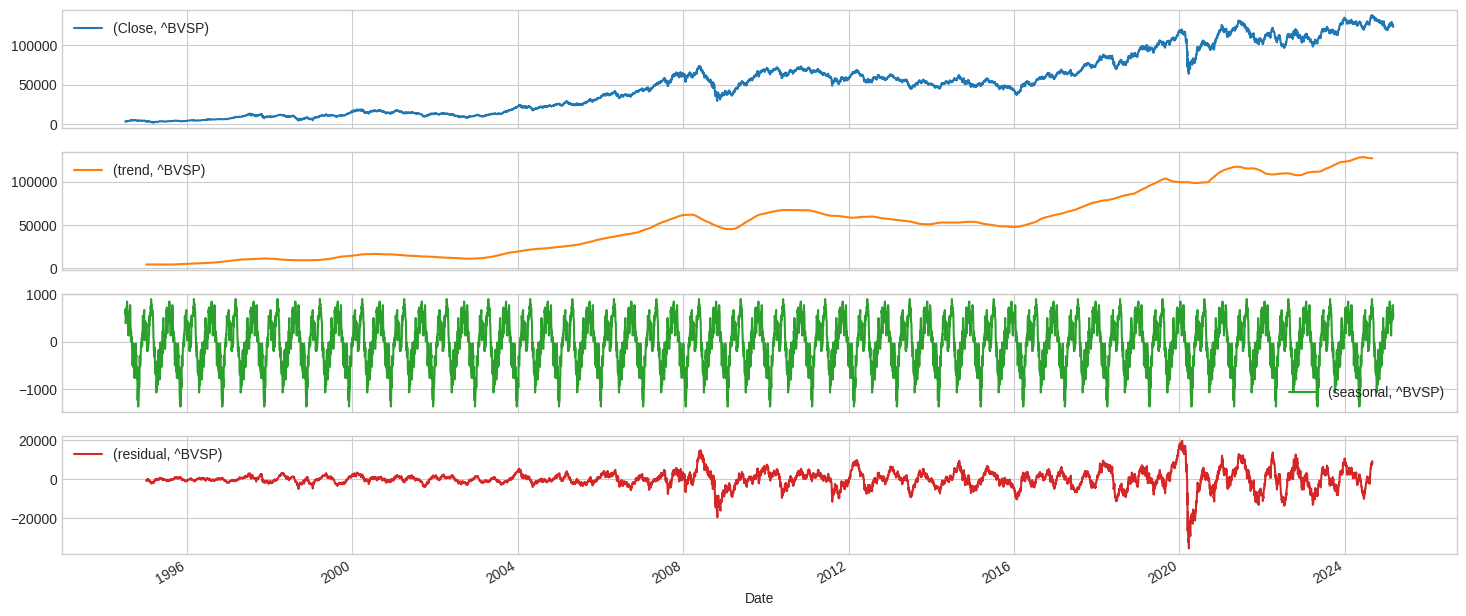

In [493]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Selecionando a série correta
serie_temporal = df[('Close', '^BVSP')].dropna()

# Decomposição sazonal
stl = seasonal_decompose(serie_temporal, period=252)  # 252 dias úteis = ~1 ano

# Adicionando os componentes ao DataFrame
df[('trend', '^BVSP')] = stl.trend.shift(1)
df[('seasonal', '^BVSP')] = stl.seasonal.shift(1)
df[('residual', '^BVSP')] = stl.resid.shift(1)

# Plotando os componentes
df[[('Close', '^BVSP'), ('trend', '^BVSP'), ('seasonal', '^BVSP'), ('residual', '^BVSP')]].plot(subplots=True, figsize=(18, 8))


In [494]:
# 🔹 Imputação de valores NaN usando KNN
imputer = KNNImputer(n_neighbors=5)  # Use 5 vizinhos mais próximos
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)



In [495]:
# 🔹 Verificar se ainda há valores NaN
print("Valores NaN após imputação por KNN:")
print(df_imputed.isna().sum())

Valores NaN após imputação por KNN:
Price     Ticker
Close     ^BVSP     0
High      ^BVSP     0
Low       ^BVSP     0
Open      ^BVSP     0
Volume    ^BVSP     0
MA_30     ^BVSP     0
trend     ^BVSP     0
seasonal  ^BVSP     0
residual  ^BVSP     0
dtype: int64


In [496]:
# 🔹 Criar Features
def create_features(df):
    for i in range(1, 6):
        df[f'Lag{i}'] = df['Close'].shift(i)
    df['Daily_Return'] = df['Close'].pct_change()
    df['MA_7'] = df['Close'].rolling(window=7, min_periods=1).mean()
    df['MA_30'] = df['Close'].rolling(window=30, min_periods=1).mean()
    df['Volatility'] = df['Close'].pct_change().rolling(window=7, min_periods=1).std()
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['BB_Mid'] = df['Close'].rolling(window=20, min_periods=1).mean()
    std_dev = df['Close'].rolling(window=20, min_periods=1).std().squeeze()
    df['BB_Upper'] = df['BB_Mid'] + (std_dev * 2)
    df['BB_Lower'] = df['BB_Mid'] - (std_dev * 2)
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14, min_periods=1).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df.dropna(inplace=True)
    return df

In [ ]:
model = RandomForestRegressor(
    n_estimators=100,       # Reduzir o número de árvores
    max_depth=5,           # Reduzir ainda mais a profundidade
    min_samples_split=10,  # Aumentar amostras mínimas para dividir
    min_samples_leaf=5,   # Aumentar amostras mínimas nas folhas
    max_features='sqrt',   # Limitar features consideradas em cada split
    random_state=42
)

In [ ]:
Q1 = df[('Close', '^BVSP')].quantile(0.25)
Q3 = df[('Close', '^BVSP')].quantile(0.75)
IQR = Q3 - Q1
df = df[(df[('Close', '^BVSP')] >= Q1 - 1.5*IQR) & (df[('Close', '^BVSP')] <= Q3 + 1.5*IQR)]

In [ ]:
# 🔹 Verificar o intervalo de datas do DataFrame
print("Data mínima:", df.index.min())
print("Data máxima:", df.index.max())

# 🔹 Definir cutoff_date dentro do intervalo de datas do DataFrame
# Exemplo: Use 80% dos dados para treino e 10% para teste
cutoff_date = df.index[int(0.9 * len(df))]  # 90% dos dados para treino
print("Cutoff date:", cutoff_date)

# 🔹 Separação treino/teste baseada no tempo
train = df.loc[:cutoff_date].copy()
test = df.loc[cutoff_date:].copy()

# 🔹 Verificar o tamanho dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", len(train))
print("Tamanho do conjunto de teste:", len(test))

if len(train) == 0:
    raise ValueError("O conjunto de treino está vazio. Verifique o cutoff_date.")

# 🔹 Definir X e y
X = df.drop(columns=[('Close', '^BVSP')])  # Ajustado para multi-index
y = df[('Close', '^BVSP')]  # Ajustado para multi-index
X_train, X_test = X.loc[train.index], X.loc[test.index]
y_train, y_test = y.loc[train.index], y.loc[test.index]

# 🔹 Verificar o tamanho de X_train e y_train
print("Tamanho de X_train:", X_train.shape)
print("Tamanho de y_train:", y_train.shape)

if X_train.shape[0] == 0:
    raise ValueError("X_train está vazio. Verifique as colunas e o cutoff_date.")

# 🔹 Normalização
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔹 Treinar modelo (Exemplo com RandomForest)
model = RandomForestRegressor(n_estimators=90, random_state=42)
model.fit(X_train_scaled, y_train)

# 🔹 Criar datas futuras (próximos 5 dias úteis)
future_dates = [df.index[-1] + BDay(i) for i in range(1, 6)]

# 🔹 Pegar features usadas no treinamento
selected_features = X_train.columns.tolist()

# 🔹 Criar dataframe para previsão futura
future_features = pd.DataFrame(np.tile(df[selected_features].iloc[-1].values, (5, 1)),
                               columns=selected_features, index=future_dates)

# 🔹 Aplicar normalização aos dados futuros
future_features_scaled = scaler.transform(future_features)

# 🔹 Fazer previsão
future_predictions = model.predict(future_features_scaled)

# 🔹 Ajustar previsões com pequena variação aleatória
future_predictions_adjusted = [
    pred * (1 + np.random.normal(scale=0.02)) for pred in future_predictions
]

# 🔹 Exibir previsões corrigidas
print("Previsões corrigidas para os próximos 5 dias:")
for i, pred in enumerate(future_predictions_adjusted, 1):
    print(f'Dia {i}: {pred:.2f}')

In [ ]:

# 🔹 Validação Cruzada para Ajuste de Hiperparâmetros (RandomForest)
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 'log2'],  # Hiperparâmetro válido para RandomForest
    'bootstrap': [True, False]         # Controla se as amostras são bootstrapadas
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1  # Usar todos os núcleos do processador
)

grid_search.fit(X_train_scaled, y_train)

print("Melhores parâmetros:", grid_search.best_params_)

In [ ]:
print("Data mínima:", df.index.min())
print("Data máxima:", df.index.max())
print("Cutoff date:", cutoff_date)
print("Tamanho do conjunto de treino:", len(train))
print("Tamanho do conjunto de teste:", len(test))
print("Tamanho de X_train:", X_train.shape)
print("Tamanho de y_train:", y_train.shape)


In [ ]:
last_close = float(df['Close'].iloc[-1].values[0])  # Pegando o primeiro valor da Series
df['Close'] = df['Close'].astype(float)  # Converte valores para float


In [ ]:

# 🔹 Configurando o estilo do gráfico
plt.style.use('seaborn-v0_8-whitegrid')

# 🔹 Criando o gráfico
fig, ax1 = plt.subplots(figsize=(14, 6))

# 🔹 Linha azul dos valores reais
ax1.plot(df.index[-10:], df['Close'][-10:], label='Valores Reais Recentes',
         color='royalblue', marker='o', linewidth=2, alpha=0.8)

# 🔹 Ligação entre último valor real e primeiro previsto
ax1.plot([df.index[-1], future_features.index[0]],
         [last_close, float(future_predictions_adjusted[0])],
         color='gray', linestyle='dotted', linewidth=1.2, alpha=0.6)



# 🔹 Linha vermelha das previsões ajustadas
ax1.plot(future_features.index, future_predictions_adjusted,
         label='Previsões Ajustadas (Próximos Dias)',
         color='crimson', linestyle='--', marker='s', linewidth=2, alpha=0.8)

# 🔹 Anotação dos valores com fundo branco para melhor legibilidade
df[('Close', '^BVSP')] = pd.to_numeric(df[('Close', '^BVSP')], errors='coerce')
df = df.dropna(subset=[('Close', '^BVSP')])  # Remove linhas com NaN


for date, value in zip(df.index[-10:], df[('Close', '^BVSP')].iloc[-10:]):
    ax1.annotate(f'{value:.0f}', xy=(date, value), xytext=(0, 10),
                 textcoords='offset points', fontsize=9, color='navy',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))




for date, prediction in zip(future_features.index, future_predictions_adjusted):
    ax1.annotate(f'{prediction:.0f}', xy=(date, prediction), xytext=(0, 10),
                 textcoords='offset points', fontsize=9, color='darkred',
                 bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

# 🔹 Melhorando o formato do eixo X
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax1.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax1.tick_params(axis='x', rotation=45)

# 🔹 Melhorando a legenda
ax1.legend(fontsize=12, loc='best', frameon=True, edgecolor='gray')

# 🔹 Melhorando título e rótulos
ax1.set_title('Prvisão de Fechamento e Próximas Projeções', fontsize=18, fontweight='bold', pad=15)
ax1.set_xlabel(' Data', fontsize=13)
ax1.set_ylabel(' Preço', fontsize=13)

# 🔹 Ajustando o layout para evitar cortes
plt.tight_layout()

# 🔹 Exibindo o gráfico
plt.show()


In [ ]:
y_train_log = np.log(y_train)
model.fit(X_train_scaled, y_train_log)

# Para previsões: reverta a transformação
y_pred = np.exp(model.predict(X_test_scaled))

In [ ]:
# 🔹 Fazer previsões no conjunto de teste
y_pred = model.predict(X_test_scaled)

# 🔹 Calcular métricas
mse = mean_squared_error(y_test, y_pred)  # MSE
rmse = np.sqrt(mse)  # RMSE manual
mae = mean_absolute_error(y_test, y_pred)  # MAE
r2 = r2_score(y_test, y_pred)  # R²

# 🔹 Exibir métricas
print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

In [ ]:
print("Último valor real:", y_test.iloc[-1])
print("Média do valor real:", y_test.mean())

In [ ]:
# Calcular métricas no treino
y_train_pred = model.predict(X_train_scaled)
r2_train = r2_score(y_train, y_train_pred)
print("R² no treino:", r2_train)

In [ ]:
# Gráfico de resíduos (valores reais vs. erros)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Reais')
plt.ylabel('Resíduos (Real - Previsto)')
plt.title('Análise de Resíduos')
plt.show()

In [ ]:
# Histograma dos resíduos
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50)
plt.xlabel('Erro (Real - Previsto)')
plt.ylabel('Frequência')
plt.title('Distribuição dos Erros')
plt.show()

In [ ]:
# Calcular R² no treino e no teste
r2_train = model.score(X_train_scaled, y_train)
r2_test = model.score(X_test_scaled, y_test)
print(f"R² Treino: {r2_train:.4f}")
print(f"R² Teste: {r2_test:.4f}")

In [ ]:
df[('Close', '^BVSP')]
